In [1]:
!git clone https://github.com/prabaey/SynSUM.git

Cloning into 'SynSUM'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 218 (delta 8), reused 7 (delta 4), pack-reused 202 (from 2)
Receiving objects: 100% (218/218), 457.50 MiB | 33.67 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Updating files: 100% (44/44), done.


In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

In [3]:
def convert(df):
    mapping = {
        "yes": 1, "no": 0,
        "high": 2, "low": 1, "none": 0
    }
    
    for col in df.iloc[:, :12].columns:
        df[col] = df[col].map(mapping).fillna(df[col])  # Giữ nguyên giá trị nếu không có trong mapping
    
    return df

In [4]:
cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

### File train 8k
train_df = pd.read_pickle('/kaggle/input/diagnosis-of-pneumonia/concatenated_dataFileP.p')
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')  

test_df = pd.read_pickle('/kaggle/working/SynSUM/data/emb/df_test_emb.p')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')  
#val_df = pd.read_pickle('/kaggle/working/SynSUM/data/emb/df_test_emb.p').drop(columns=cols_to_drop, errors='ignore')

train_df = convert(train_df)
test_df = convert(test_df)
#val_df = convert(val_df)
# Tạo nhãn kết hợp từ hai cột pneu và cold
count_values = train_df[['pneu', 'inf']].astype(str).agg('-'.join, axis=1)

# Kiểm tra số lượng mẫu mỗi nhóm nhãn
print(count_values.value_counts())

0-0    6057
0-1    1856
1-0      56
1-1      31
Name: count, dtype: int64


In [5]:
train_df.iloc[:, 0:5]

,asthma,smoking,COPD,winter,hay_fever
0,0,0,0,0,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,0,0
...,...,...,...,...,...
7995,0,0,0,0,0
7996,0,0,0,0,0
7997,0,0,0,0,0
7998,0,0,0,0,0


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision


def NN_model_train(target, df_train, df_test, emb='hist_emb'):
    
    # Chuyển embeddings từ dạng list thành numpy array
    X_train = np.array(df_train.iloc[:, 0:5].drop(columns=target, errors='ignore'))
    X_test = np.array(df_test.iloc[:, 0:5].drop(columns=target, errors='ignore'))

    X_train = np.concatenate([X_train, df_train[emb].tolist()], axis=1)
    X_test = np.concatenate([X_test, df_test[emb].tolist()], axis=1)

    y_train = df_train[target].values  # Đảm bảo y_train là numpy array
    y_true = df_test[target].values  

    print("y_train shape:", y_train.shape)
    print("X_train: ", X_train.shape[1])
    # Định nghĩa model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='relu')
    ])

    # Chọn loss function
    loss = 'binary_crossentropy'
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    
    model.summary()

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: class_weights[0], 1: class_weights[1]}

    print("Class Weights:", class_weights)

    # Huấn luyện mô hình
    model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, class_weight=class_weights)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Bước 5: Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Bước 6: Vẽ đồ thị
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for " + target)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()
    return model

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8353 - loss: 1.3531 - val_accuracy: 0.8163 - val_loss: 0.3361
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6481 - loss: 0.6496 - val_accuracy: 0.9625 - val_loss: 0.1441
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7186 - loss: 1.2966 - val_accuracy: 0.7794 - val_loss: 0.4258
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8370 - loss: 0.6699 - val_accuracy: 0.9500 - val_loss: 0.1531
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8952 - loss: 0.6818 - val_accuracy: 0.9081 - val_loss: 0.2437
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8989 - loss: 0.6298 - val_accuracy: 0.9638 - val_loss: 0.1060
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9234 - loss: 0.6362 - val_accuracy: 0.9156 - val_loss: 0.2410
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

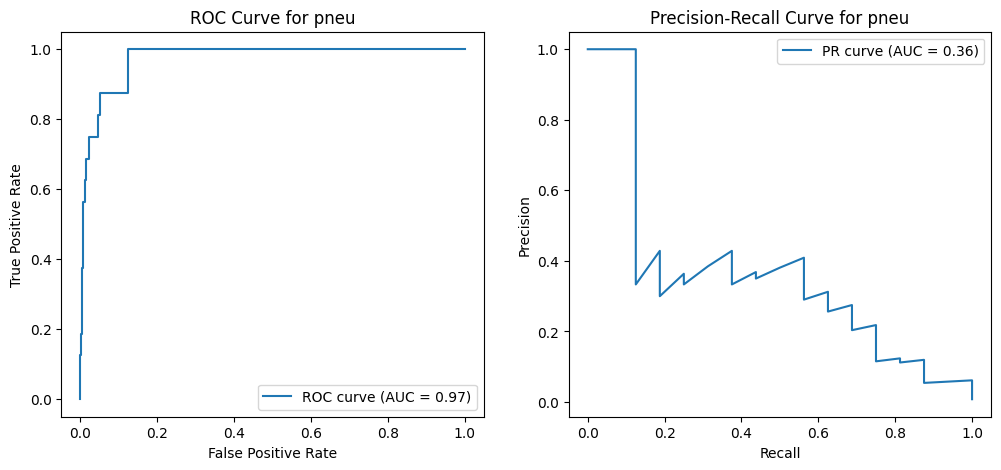

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7633 - loss: 8.0873 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

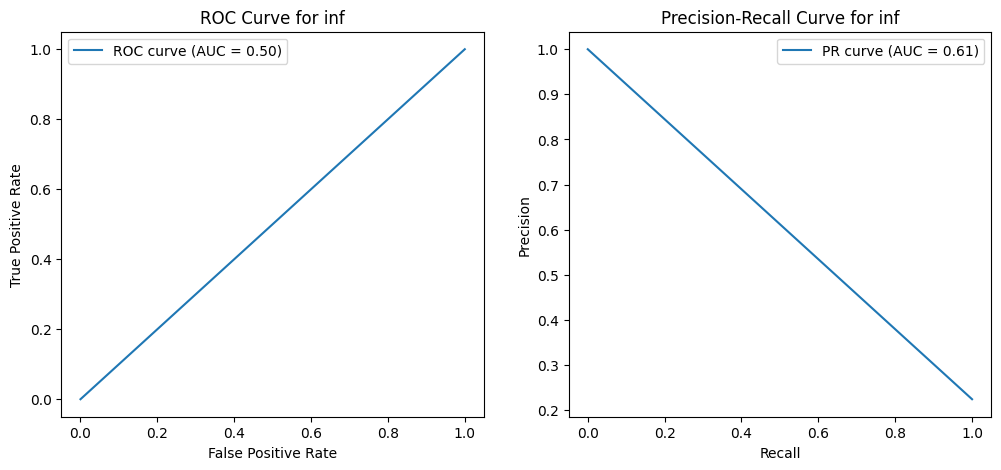

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8474 - loss: 0.9398 - val_accuracy: 0.7212 - val_loss: 0.4737
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7941 - loss: 0.4141 - val_accuracy: 0.6925 - val_loss: 0.5627
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8400 - loss: 0.3643 - val_accuracy: 0.8475 - val_loss: 0.3953
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9140 - loss: 0.2993 - val_accuracy: 0.9019 - val_loss: 0.2567
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9170 - loss: 0.2667 - val_accuracy: 0.9831 - val_loss: 0.0784
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.3278 - val_accuracy: 0.9887 - val_loss: 0.1379
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 1.0109 - val_accuracy: 0.7981 - val_loss: 0.7651
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

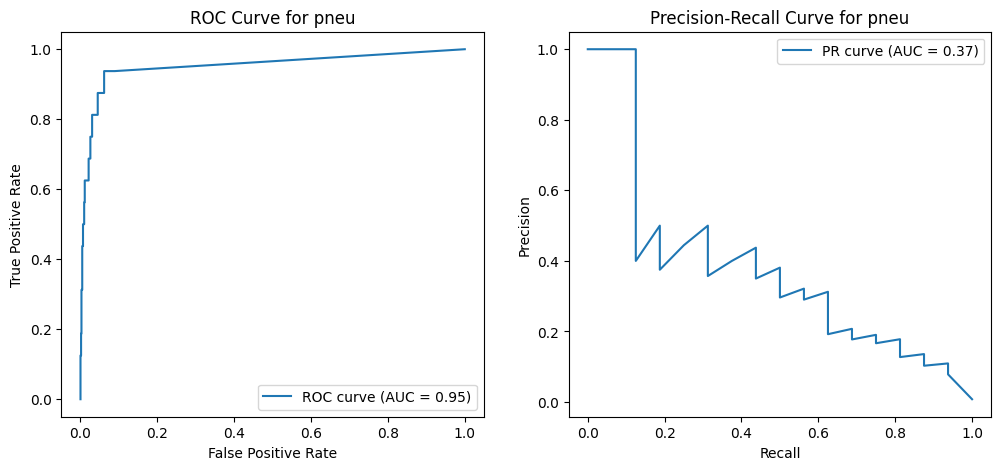

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7686 - loss: 0.6571 - val_accuracy: 0.8131 - val_loss: 0.4645
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8292 - loss: 0.5385 - val_accuracy: 0.8637 - val_loss: 0.3614
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8147 - loss: 0.6222 - val_accuracy: 0.8281 - val_loss: 0.4308
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8186 - loss: 0.4461 - val_accuracy: 0.8594 - val_loss: 0.3529
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.5850 - val_accuracy: 0.8612 - val_loss: 0.3795
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8577 - loss: 0.4455 - val_accuracy: 0.8569 - val_loss: 0.4304
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8190 - loss: 0.5051 - val_accuracy: 0.8456 - val_loss: 0.4466
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

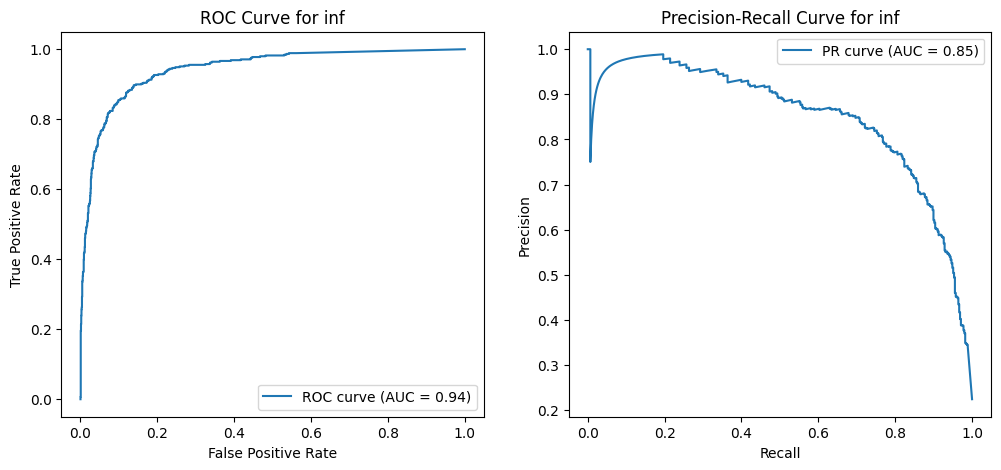

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8444 - loss: 0.8702 - val_accuracy: 0.7694 - val_loss: 0.4080
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7557 - loss: 0.4955 - val_accuracy: 0.7875 - val_loss: 0.3913
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8024 - loss: 0.4511 - val_accuracy: 0.8944 - val_loss: 0.2496
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8648 - loss: 0.3724 - val_accuracy: 0.9500 - val_loss: 0.1476
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9021 - loss: 0.3305 - val_accuracy: 0.9137 - val_loss: 0.2808
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9174 - loss: 0.3217 - val_accuracy: 0.9388 - val_loss: 0.1695
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2709 - val_accuracy: 0.9362 - val_loss: 0.2453
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

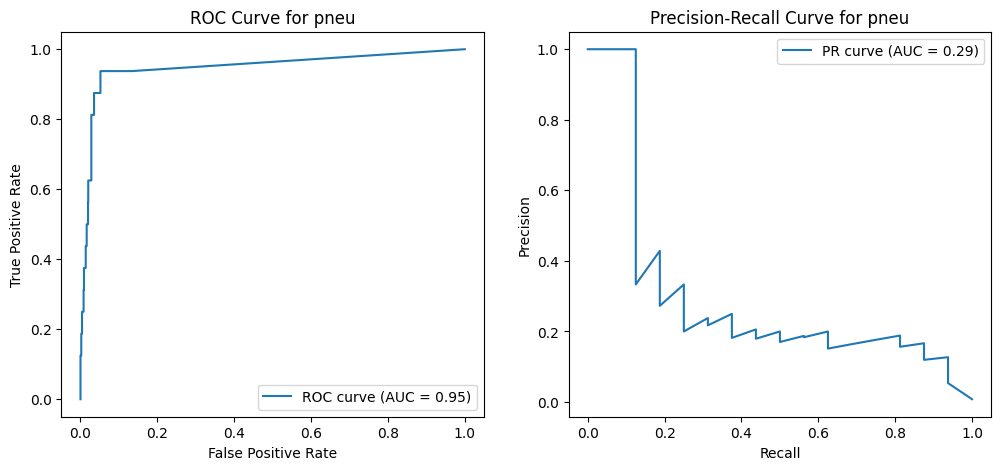

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7450 - loss: 0.7236 - val_accuracy: 0.8306 - val_loss: 0.4822
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8379 - loss: 0.4171 - val_accuracy: 0.8681 - val_loss: 0.3590
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8578 - loss: 0.3864 - val_accuracy: 0.8619 - val_loss: 0.4580
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8512 - loss: 0.4009 - val_accuracy: 0.7925 - val_loss: 0.5163
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8279 - loss: 0.3954 - val_accuracy: 0.8675 - val_loss: 0.4582
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3643 - val_accuracy: 0.8963 - val_loss: 0.3250
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.3869 - val_accuracy: 0.8037 - val_loss: 0.4105
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

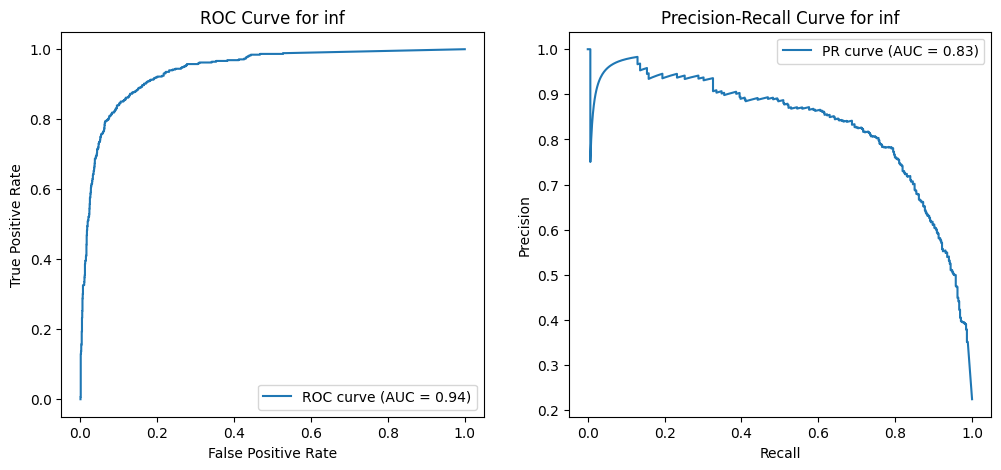

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8501 - loss: 1.4073 - val_accuracy: 0.8294 - val_loss: 0.3309
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8164 - loss: 1.3035 - val_accuracy: 0.8481 - val_loss: 0.4093
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8702 - loss: 1.2271 - val_accuracy: 0.8838 - val_loss: 0.2694
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9028 - loss: 1.1703 - val_accuracy: 0.8931 - val_loss: 0.3680
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9180 - loss: 1.1692 - val_accuracy: 0.9237 - val_loss: 0.2642
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9223 - loss: 1.1456 - val_accuracy: 0.9194 - val_loss: 0.3455
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9315 - loss: 1.1307 - val_accuracy: 0.9500 - val_loss: 0.2000
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

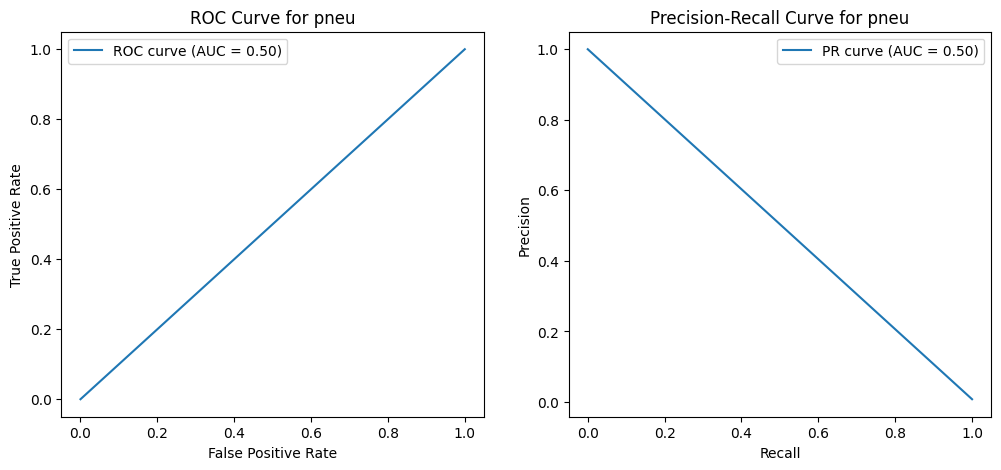

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7480 - loss: 0.9496 - val_accuracy: 0.7519 - val_loss: 0.6795
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8058 - loss: 0.4582 - val_accuracy: 0.8425 - val_loss: 0.5884
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8437 - loss: 0.4439 - val_accuracy: 0.8587 - val_loss: 0.5489
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8276 - loss: 0.5132 - val_accuracy: 0.8050 - val_loss: 0.5362
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8287 - loss: 0.4621 - val_accuracy: 0.7719 - val_loss: 0.5269
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8051 - loss: 0.4311 - val_accuracy: 0.8706 - val_loss: 0.3869
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8506 - loss: 0.3937 - val_accuracy: 0.8731 - val_loss: 0.4064
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

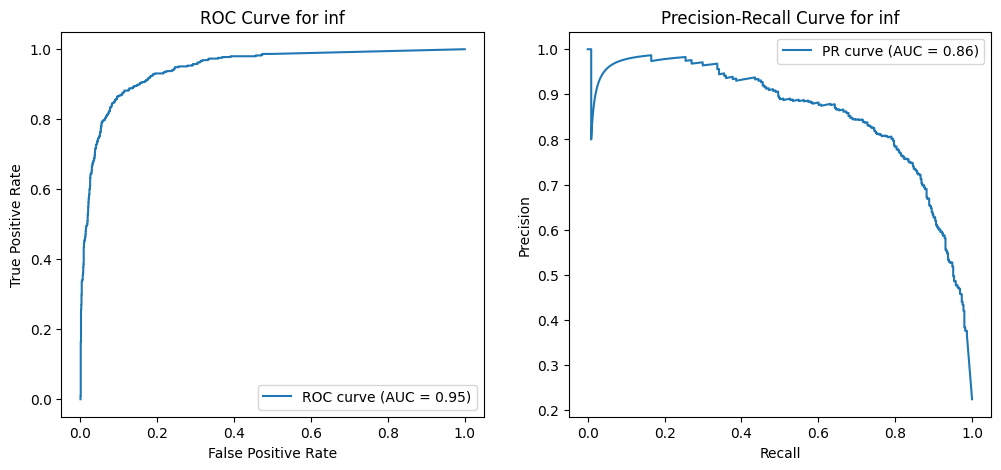

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9877 - loss: 8.7285 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

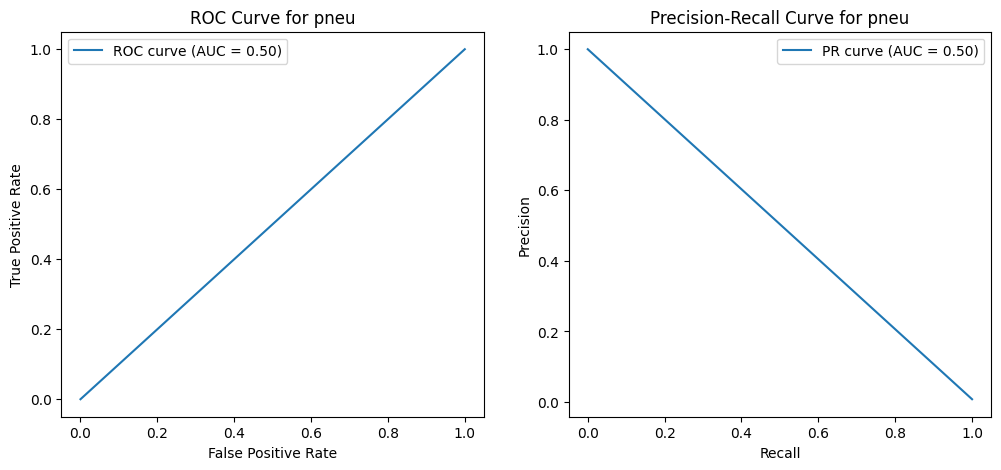

y_train shape: (8000,)
X_train:  773


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7889 - loss: 0.8427 - val_accuracy: 0.8600 - val_loss: 0.4027
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8346 - loss: 0.4300 - val_accuracy: 0.8206 - val_loss: 0.5905
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7332 - loss: 0.6664 - val_accuracy: 0.8444 - val_loss: 0.3859
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7508 - loss: 0.6852 - val_accuracy: 0.8394 - val_loss: 0.3920
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8214 - loss: 0.5919 - val_accuracy: 0.7925 - val_loss: 0.4869
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8135 - loss: 0.3991 - val_accuracy: 0.8725 - val_loss: 0.3857
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8435 - loss: 0.4094 - val_accuracy: 0.8775 - val_loss: 0.3691
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

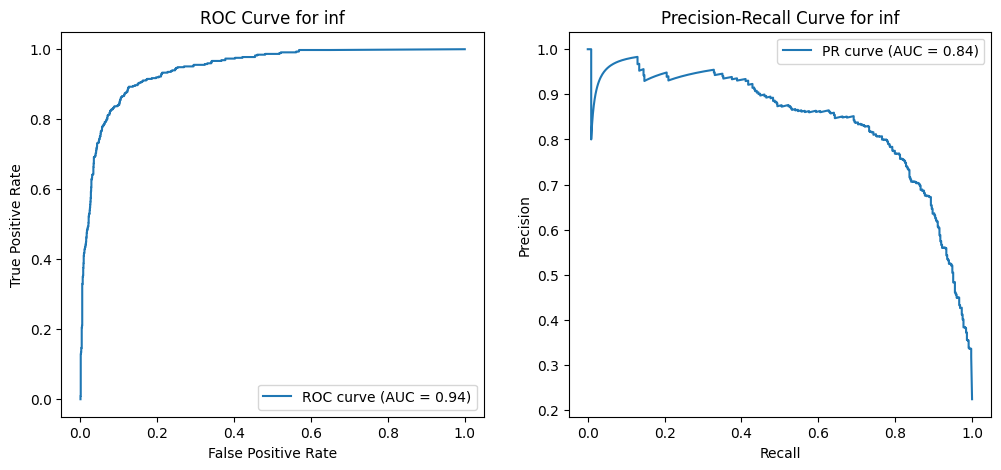

In [7]:
import tensorflow as tf
import random

seeds = [327, 100, 105, 888, 521]

targets = ["pneu", "inf"]
for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    for i in targets:
        model = NN_model_train(i, train_df, test_df)
